In [101]:
# import block

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import solve_ivp

%matplotlib inline

# not to burn my eyes!!
import datetime

hour = datetime.datetime.now().hour
if hour > 18 and hour < 8:
    plt.style.use("dark_background")
else:
    plt.style.use("default")

# ODE System for 2D Motion
Consider an object that is being thrown in the air. The object will follow a particular trajectory and then falls in a denser fluid (refered as fluid for convenience). We will design a single model that describes the motion of the object through both fluids. Note that we will not consider the period when the object is entering the fluid. As soon as the object hits the fluid, we will consider the motion of the object only in the fluid.

The system of ODEs for 2D motion is given by the following.
## Motion in Air
1. The velocity of the object in the x/y-direction is given by the derivative of the position in the x/y-direction with respect to time.
$$ \frac{dx_{air}}{dt} = v_x, ~~ \frac{dy_{air}}{dt} = v_y $$
2. The forces acting on the object in the x/y-direction affect its speed in the reletive direction.
$$ \frac{dv_{x, air}}{dt} = - \frac{c_{air}\cdot v_{x, air}}{m}$$
$$ \frac{dv_{y, air}}{dt} = - g - \frac{c_{air}\cdot v_{y, air}}{m}$$

where $c_{air}$ is the drag coefficient, $m$ is the mass of the object, and $g$ is the acceleration due to gravity.

## Motion in Fluid
As the object enters the fluid, the system describing the motion of the object changes. However, the general form of the system remains similar.
1. The velocity of the object in the x/y-direction is given by the derivative of the position in the x/y-direction with respect to time.
$$ \frac{dx_{fluid}}{dt} = v_x, ~~ \frac{dy_{fluid}}{dt} = v_y$$
2. The horizontal motion of the object in the fluid is affected by the drag force only.
$$ \frac{dv_{x, fluid}}{dt} = - \frac{c_{fluid} \cdot v_{x, fluid}}{m}$$
3. The vertical motion of the object in the fluid is affected by the drag force and the buoyant force. The buoyant force is proportional to the volume of the fluid displaced by the object. Since the object is assumed to be a sphere, the volume of the fluid displaced by the object is given by the following formula.
$$ V_{displaced} = V_{object} - V_{sphere~cap~above~surface} $$
$$ V_{displaced} = \frac{4}{3}\pi r^3 - \frac{\pi h^2}{3}(3r - h)$$
where $r$ is the radius of the sphere and $h$ is the height of the sphere above the surface of the fluid. Note that  $0 \leq h \leq 2r$. Thus, this formula can only be applied when the object is partially submerged in the fluid. Therefore, we can slightly modify the formula to apply it to the case when the object is fully submerged in the fluid.
$$ V_{displaced} = \frac{4}{3}\pi r^3 - \frac{\pi \eta^2}{3}(3r - \eta) $$
$$ \eta := \max\{\min\{y+r, 2r\}, 0\}$$
If the object is fully submerged in the fluid, then $h = 0$ and the formula simplifies to the following.
$$ V_{displaced} = \frac{4}{3}\pi r^3$$
If the object is completely out of the fluid, then $h = 2r$ and the formula simplifies to the following.
$$ V_{displaced} = 0$$

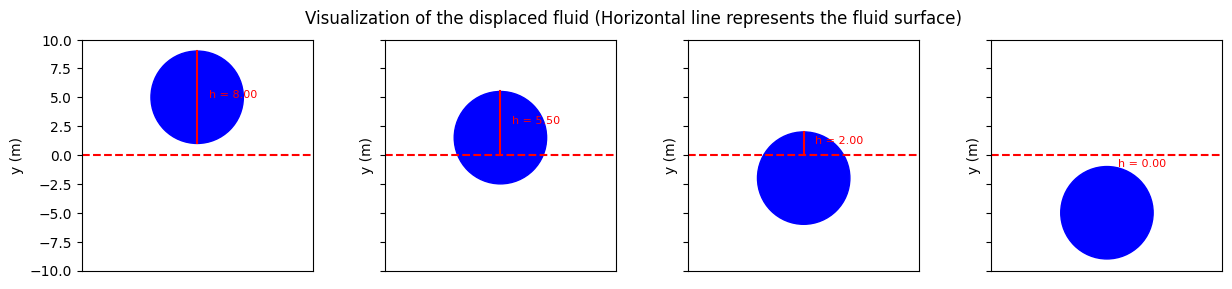

In [102]:
# visualization of the displaced fluid according to the above formula
sample_r = 4.0
position_1 = [0.0, 5.0]
position_2 = [0.0, 1.5]
position_3 = [0.0, -2]
position_4 = [0.0, -5.0]


def calculate_submerge(pos, r):
    object_top = pos[1] + r
    return np.maximum(np.minimum(object_top, 2 * r), 0.0)
    # this is equivalent to the following block
    # if object_top <= 0:
    #     return 0.0
    # elif object_top < 2 * r:
    #     return object_top
    # else:
    #     return 2 * r


def plot_submersion_height(sample_r, pos, ax):
    object_circle = plt.Circle(pos, sample_r, color="blue")
    ax.add_artist(object_circle)
    h = calculate_submerge(pos, sample_r)
    ax.plot(
        [pos[0], pos[0]],
        [pos[1] + sample_r, pos[1] + sample_r - h],
        color="red",
    )
    ax.text(
        pos[0] + 1,
        pos[1] + sample_r - h / 2,
        f"h = {h:.2f}",
        fontsize=8,
        color="red",
    )


fig, axes = plt.subplots(1, 4, figsize=(15, 3), sharey="all")
plt.suptitle(
    "Visualization of the displaced fluid (Horizontal line represents the fluid surface)"
)
for ax in axes:
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.set_aspect("equal")
    ax.xaxis.set_visible(False)
    ax.set_ylabel("y (m)")
    ax.hlines(0, -10, 10, color="red", linestyle="--")

plot_submersion_height(sample_r, position_1, axes[0])
plot_submersion_height(sample_r, position_2, axes[1])
plot_submersion_height(sample_r, position_3, axes[2])
plot_submersion_height(sample_r, position_4, axes[3])

plt.show()

We can now write the equation for the vertical motion of the object in the fluid.
$$ \frac{dv_{y, fluid}}{dt} = - g + \frac{\rho_{fluid}\cdot V_{displaced}\cdot g}{m}  - \frac{c_{fluid}\cdot v_{y, fluid}}{m}$$

where $c_{fluid}$ is the drag coefficient of the fluid, $\rho_{fluid}$ is the density of the fluid, and $g$ is the acceleration due to gravity.
# Combination of the Two Systems
We can combine the two systems by introducing a sigmoid-esque switch function that determines when the object enters the fluid. The switch function is given by the following.
$$ S(y) = \frac{1}{1 + e^{-\alpha(y - y_{fluid})}}$$
where $\alpha$ is a constant that determines the steepness of the sigmoid curve, $y_{fluid}$ is the height of the fluid surface, and $y$ is the height of the object above the surface of the fluid. The switch function is such that $S(y) \approx 0$ when $y \ll y_{fluid}$ and $S(y) \approx 1$ when $y \gg y_{fluid}$. The switch function is used to determine the drag coefficient and the density of the fluid acting on the object.

The combined system of ODEs is given by the following.
$$ \frac{dx}{dt} = v_x, ~~ \frac{dy}{dt} = v_y $$
$$ \frac{dv_x}{dt} = S(y)\cdot \frac{dv_{x, air}}{dt} + (1 - S(y))\cdot \frac{dv_{x, fluid}}{dt} $$
$$ \frac{dv_y}{dt} = S(y)\cdot \frac{dv_{y, air}}{dt} + (1 - S(y))\cdot \frac{dv_{y, fluid}}{dt} $$

## Plotting the Switch function for Different Values of $\alpha$

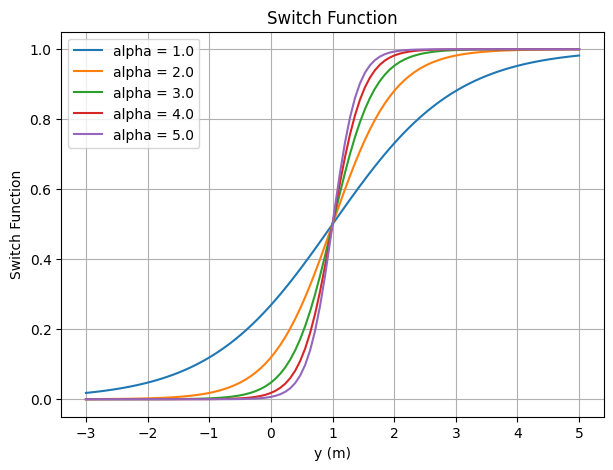

In [103]:
def switch_function(y, r, alpha=1.0):
    y = y - r
    # consider y_fluid to be zero at all times
    return 1 / (1 + np.exp(-alpha * y))


def displaced_volume(y, r):
    object_top = y + r
    h = np.maximum(np.minimum(object_top, 2 * r), 0.0)
    volume = 4 / 3 * np.pi * r**3
    cap = np.pi / 3 * h**2 * (3 * r - h)
    return volume - cap


y = np.linspace(-3, 5, 100)
r = 1.0
alpha_values = np.linspace(1, 5, 5)
plt.figure(figsize=(7, 5))
plt.title("Switch Function")
plt.xlabel("y (m)")
plt.ylabel("Switch Function")
for alpha in alpha_values:
    plt.plot(y, switch_function(y, r, alpha), label=f"alpha = {alpha}")
plt.legend()
plt.grid()
plt.show()

In [104]:
def ode_system(t, state, params):
    x, y, vx, vy = state

    # constants and parameters
    c_air, c_fluid, rho_fluid, g, m, r, alpha = params

    # calculate the bouyant force
    displaced_fluid = displaced_volume(y, r)
    bouyant_force = displaced_fluid * g * rho_fluid

    # velocity vectors
    dxdt = vx
    dydt = vy

    # acceleration vectors
    dvxairdt = -c_air * vx / m
    dvxfluiddt = -c_fluid * vx / m
    dvyairdt = -g - c_air * vy / m
    dvyfluiddt = -g - c_fluid * vy / m + bouyant_force / m

    # combined system for fluid and air
    dvxdt = (
        switch_function(y, r, alpha) * dvxairdt
        + (1 - switch_function(y, r, alpha)) * dvxfluiddt
    )
    dvydt = (
        switch_function(y, r, alpha) * dvyairdt
        + (1 - switch_function(y, r, alpha)) * dvyfluiddt
    )

    return [dxdt, dydt, dvxdt, dvydt]

# Numerical Integration with SciPy

In [ ]:
# parameter setup
c_air = 30.0  # drag coefficient for air (kg/m)
c_fluid = 1000.0  # drag coefficient for fluid (kg/m)
rho_fluid = 1000.0  # density of fluid (kg/m^3)
g = 9.81  # acceleration due to gravity (m/s^2)
m = 1000.0  # mass of the object (kg)
r = 1.0  # radius of the object (m)
alpha = 1.0  # alpha for the switch function
params = [c_air, c_fluid, rho_fluid, g, m, r, alpha]

# initial conditions
initial_position = [00.0, 10.0]
initial_velocity = [10.0, 15.0]
initial_conditions = initial_position + initial_velocity
t_span = (0, 15)  # simulation duration
t_eval = np.linspace(t_span[0], t_span[1], 450)  # time points to evaluate the solution

solution = solve_ivp(
    ode_system,
    t_span,
    initial_conditions,
    t_eval=t_eval,
    vectorized=True,
    args=(params,),
)

In [106]:
t = solution.t
x = solution.y[0]
y = solution.y[1]
vx = solution.y[2]
vy = solution.y[3]

In [107]:
contact = []
for ts in range(len(t)):
    if y[ts] <= r and y[ts] >= -r:
        contact.append(t[ts])

# Plot the solution

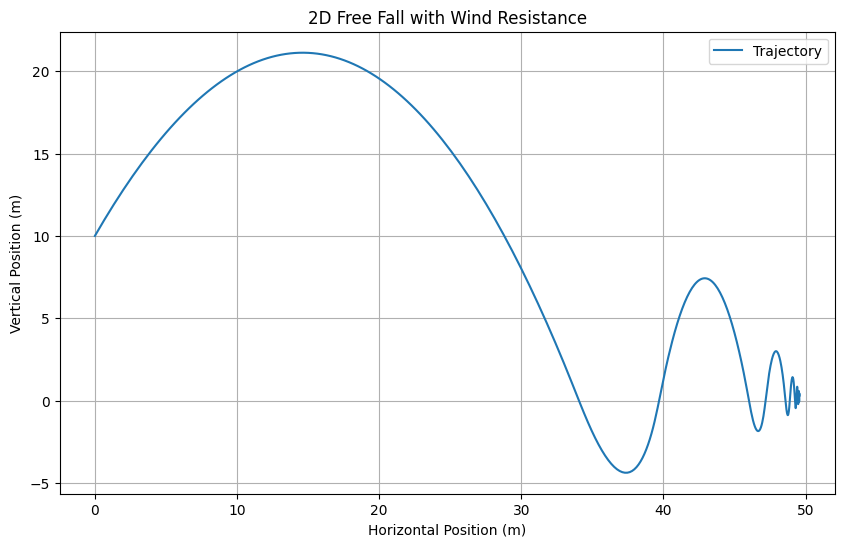

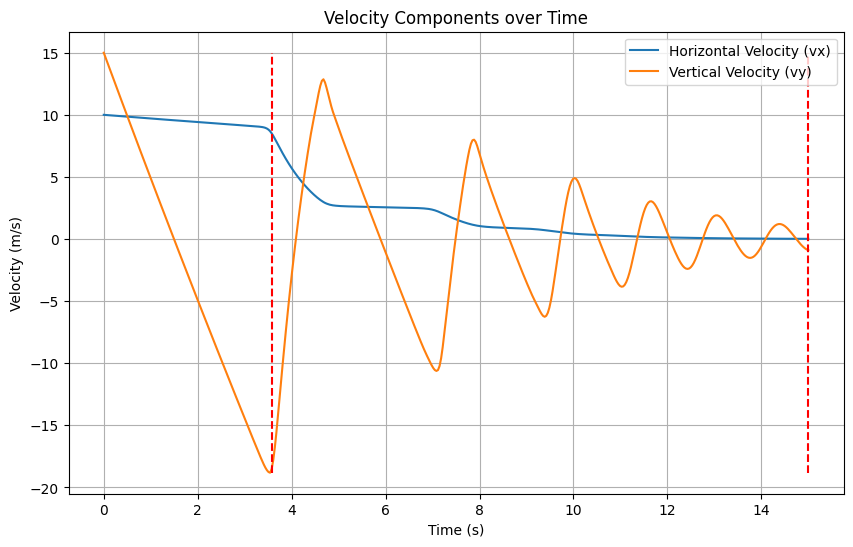

In [108]:
# plotting the trajectory
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Trajectory")
plt.xlabel("Horizontal Position (m)")
plt.ylabel("Vertical Position (m)")
plt.title("2D Free Fall with Wind Resistance")
plt.legend()
plt.grid()
plt.show()

# plot the velocity components over time
time_points = solution.t

plt.figure(figsize=(10, 6))
plt.plot(time_points, vx, label="Horizontal Velocity (vx)")
plt.plot(time_points, vy, label="Vertical Velocity (vy)")
if len(contact) > 0:
    plt.vlines(
        contact[0],
        float(min(min(vx), min(vy))),
        float(max(max(vx), max(vy))),
        linestyles="--",
        colors="red",
    )
    plt.vlines(
        contact[-1],
        float(min(min(vx), min(vy))),
        float(max(max(vx), max(vy))),
        linestyles="--",
        colors="red",
    )
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Components over Time")
plt.legend()
plt.grid()
plt.show()

# Visualize the Trajectory

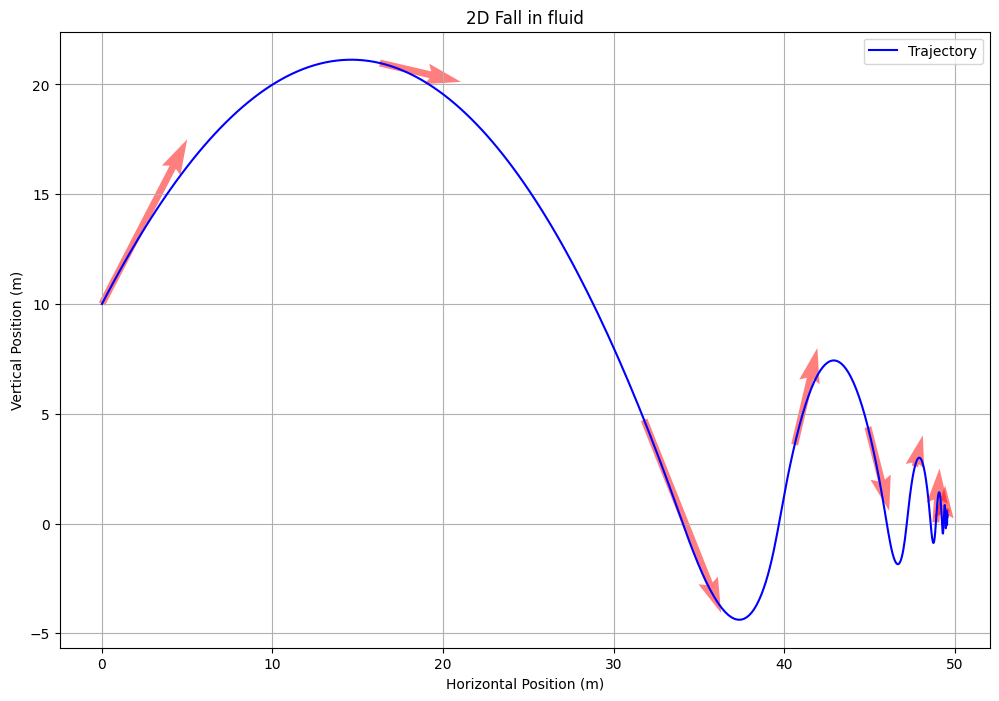

In [109]:
plt.figure(figsize=(12, 8))
plt.plot(x, y, label="Trajectory", color="blue")

# tangential vectors at different time points
for i in range(0, len(x), 50):
    plt.quiver(
        x[i],
        y[i],
        vx[i],
        vy[i],
        angles="xy",
        scale_units="xy",
        scale=2,
        color="red",
        alpha=0.5,
    )

plt.xlabel("Horizontal Position (m)")
plt.ylabel("Vertical Position (m)")
plt.title("2D Fall in fluid")
plt.legend()
plt.grid()
plt.show()

# Animate Falling Object

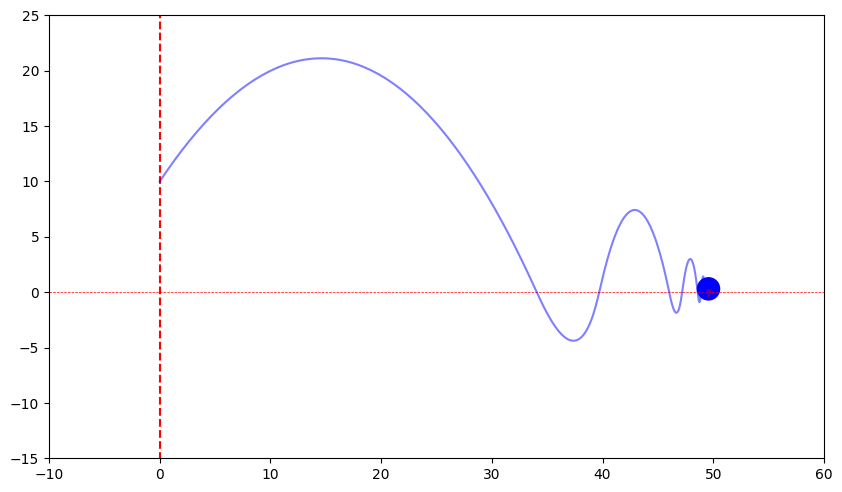

In [110]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-10, 60)
ax.set_ylim(-15, 25)
ax.set_aspect("equal")

# initialize the object
object_patch = plt.Circle((initial_position[0], initial_position[1]), r, color="blue")
ax.add_patch(object_patch)
ax.hlines(0, -10, 200, linestyles="dashed", color="r", linewidth=0.5)
ax.vlines(0, -100, 100, linestyles="dashed", color="r")

# initialize the velocity vector
velocity_vector = ax.quiver(
    initial_position[0],
    initial_position[1],
    initial_velocity[0],
    initial_velocity[1],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="red",
    alpha=0.5,
)
trace = ax.plot([], [], color="blue", alpha=0.5)


# update the animation at each frame
def update(frame):
    object_patch.center = (x[frame], y[frame])
    trace[0].set_data(x[:frame], y[:frame])
    velocity_vector.set_offsets([x[frame], y[frame]])
    velocity_vector.set_UVC(vx[frame], vy[frame])
    return object_patch, velocity_vector


anim = animation.FuncAnimation(fig, update, frames=len(x), interval=1000, blit=True)
anim.save("2d_fall_into_fluid.gif", writer="pillow", fps=30)